In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import norm
import seaborn as sns


In [29]:
# 混合ガウス分布に基づく乱数を生成する
np.random.seed(0)

# 各ガウス分布のサンプル数
n_samples = [200, 100, 200]

# 各ガウス分布の平均
means = [-2, 3, 5]

# 各ガウス分布の分散
sigmas = [1, 2, 0.5]

# GMMに従う乱数を生成
x = None
for n, mean, sigma in zip(n_samples, means, sigmas):
    samples_for_each_dist = np.random.normal(mean, sigma, int(n))
    if x is None:
        x = samples_for_each_dist
    else:
        x = np.concatenate((x, samples_for_each_dist))


<Axes: ylabel='Count'>

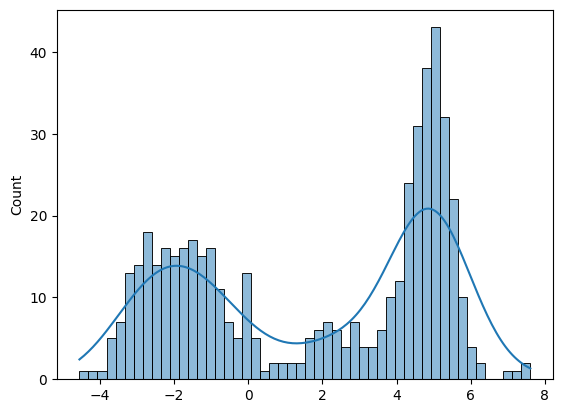

In [31]:
sns.histplot(x, bins=50, kde=True)

In [32]:
# モデルパラメータを初期化する
alpha = np.array([1./3., 1./3., 1./3.])
var = np.array([1., 1., 1.])
mu = np.array([-1, 0, 1])

# GMMを構成するガウス分布の数
n_clusters = len(alpha)


In [33]:
# 繰り返し計算でパラメータを最適化する(ここでは100回繰り返す）
n_iterations = 101
log_likelihood = np.zeros(n_iterations)
alpha_buf = []
var_buf = []
mu_buf = []

for t in range(n_iterations):
    print(f"t{t}")
    alpha_buf.append(alpha.copy())
    var_buf.append(var.copy())
    mu_buf.append(mu.copy())
    
    # Eステップ
    
    # 係数部
    coef = alpha / np.sqrt(2. * np.pi * var)
    
    # exponent: n_sample, n_clusters
    exponent = -1. * np.power(x[:, None] - mu[None, :], 2.) / (2 * var[None, :])

    # βを求める
    beta = coef[None, :] * np.exp(exponent)
    likelihood_each_sample = np.maximum(np.sum(beta, axis=1, keepdims=True), 1.e-18)
    beta = beta / likelihood_each_sample

    # 対数尤度を求める
    current_log_likelihood = np.average(np.log(likelihood_each_sample))
    log_likelihood[t] = current_log_likelihood

    # Mステップ(パラメータを更新する)
    N = np.maximum(np.sum(beta, axis=0), 1.e-18)
    
    # 事前確率を更新
    alpha = N / np.sum(N)

    # 平均値を更新
    mu = np.einsum("ij,i->j", beta, x) / N
    
    # 分散を計算
    var = np.einsum("ij,ij->j", beta, np.power(x[:, None] - mu[None, :], 2.)) / N
    var = np.maximum(var, 1.e-18)


t0
t1
t2
t3
t4
t5
t6
t7
t8
t9
t10
t11
t12
t13
t14
t15
t16
t17
t18
t19
t20
t21
t22
t23
t24
t25
t26
t27
t28
t29
t30
t31
t32
t33
t34
t35
t36
t37
t38
t39
t40
t41
t42
t43
t44
t45
t46
t47
t48
t49
t50
t51
t52
t53
t54
t55
t56
t57
t58
t59
t60
t61
t62
t63
t64
t65
t66
t67
t68
t69
t70
t71
t72
t73
t74
t75
t76
t77
t78
t79
t80
t81
t82
t83
t84
t85
t86
t87
t88
t89
t90
t91
t92
t93
t94
t95
t96
t97
t98
t99
t100


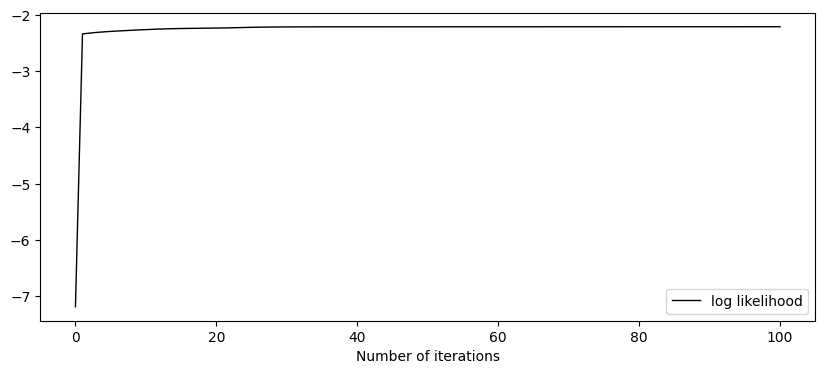

In [9]:
# 対数尤度をグラフ化する
plt.figure(figsize=(10, 4))
plt.plot(np.arange(0, n_iterations, 1), log_likelihood, color="black", linewidth=1, label="log likelihood")
plt.xlabel("Number of iterations")
plt.legend()
plt.savefig("./log_likelihood_gmm.png")
plt.show()


In [12]:
# パラメータ更新の様子をアニメーションで表示
def animation_update(t):
    plt.cla()
    plt.hist(x, bins=50, density=True, label="observed samples")

    xmin = -20
    xmax = 20
    plt.xlim([xmin, xmax])
    plt.ylim([0, 0.40])
    x_range = np.arange(-20, 20, 0.01)
    
    # GMMを描画する
    pdf = None
    for alpha, var, mu in zip(alpha_buf[t], var_buf[t], mu_buf[t]):
        pdf_each = alpha * norm.pdf(x_range, mu, np.sqrt(var))
        if pdf is None:
            pdf = pdf_each
        else:
            pdf = pdf + pdf_each

    plt.plot(x_range, pdf, color="black", linewidth=1, label=r"$p(x|\theta^{(t="+str(t)+")})$")
    plt.legend()

    if t == 0:
        plt.savefig("./initialized_gmm.png")
    if t == n_iterations - 1:
        plt.savefig("./learned_gmm.png")

# アニメーションの表示
fig = plt.figure(figsize=(10, 4))
ani = animation.FuncAnimation(fig, animation_update, interval=200, frames=n_iterations)
plt.show()


<Figure size 1000x400 with 0 Axes>